In [1]:
import negativeSelect as ns
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
%matplotlib inline

In [ ]:
### load english train and test data
englishTrain, englishTrainAlphabet = \
ns.loadTextData("../Data/english.test")

englishTest, englishTestAlphabet = \
ns.loadTextData("../Data/english.train")

In [ ]:
### do some time testing for r-chunk
nRange = np.arange(1,1000,100)
sampleSizeList = [1.0, 0.75, 0.5, 0.25, 0.1]
plt.figure()
for s in sampleSizeList:
    x = []
    timeList = []
    for n in nRange:

        x.append(n)

        startTime = time.time()

        detectors = ns.trainRChunk(englishTrain, \
                   englishTrainAlphabet, \
                   n, \
                   int(s*len(englishTrain)),
                   4,
                   len(englishTrain[0]))

        endTime = time.time()
        timeList.append(endTime - startTime)
    plt.scatter(x, timeList, label = str(s))
plt.title("Naive r-chunk training time")
plt.xlabel("Number of Detectors Trained")
plt.ylabel("Walltime(seconds)")
plt.legend(title="Fraction of Training Strings Tested")
plt.savefig("../Plots/rchunkTrainTime.eps")

In [ ]:
### do some time testing for r-contiguous
nRange = np.arange(1,1000,100)
sampleSizeList = [1.0, 0.75, 0.5, 0.25, 0.1]
plt.figure()
for s in sampleSizeList:
    x = []
    timeList = []
    for n in nRange:

        x.append(n)

        startTime = time.time()

        detectors = ns.trainRContig(englishTrain, \
                   englishTrainAlphabet, \
                   n, \
                   int(s*len(englishTrain)),\
                   4,\
                    len(englishTrain[0]))

        endTime = time.time()
        timeList.append(endTime - startTime)
    plt.scatter(x, timeList, label = str(s))
plt.title("Naive r-contiguous training time")
plt.xlabel("Number of Detectors Trained")
plt.ylabel("Walltime(seconds)")
plt.legend(title="test")
plt.savefig("../Plots/rcontigTrainTime.eps")

In [ ]:
r = 7
hilTest, hilAlphabet = ns.loadTextData("../Data/hiligaynon.txt")
midTest, midAlphabet = ns.loadTextData("../Data/middle-english.txt")
dietschTest, dietshAlphabet = ns.loadTextData("../Data/plautdietsch.txt")
xhosaTest, xhosaAlphabet = ns.loadTextData("../Data/xhosa.txt")
globalAlphabet = []
globalAlphabet.extend(hilAlphabet)
globalAlphabet.extend(midAlphabet)
globalAlphabet.extend(dietshAlphabet)
globalAlphabet.extend(xhosaAlphabet)
globalAlphabetSet = set(globalAlphabet)
globalAlphabet = list(globalAlphabetSet)

In [ ]:
languageNames = ["Hiligaynon", "Middle-English", "Plautdietsch", 'Xhosa']
languageData = [hilTest, midTest, dietschTest, xhosaTest]
numTrueAnomalies = [0, 0, 0, 0]
englishSet = set(englishTrain)

n = 10000
r = 4

result = "Name\t" +\
            "repSize\t" +\
            "time\t" +\
            "count\t" +\
            "truePerc"
result = result.expandtabs(20)
print(result)

startTime = time.time()
detectors = ns.trainRContig(englishTrain, \
               globalAlphabet, \
               n, \
               int(len(englishTrain)),\
               r,\
               10)
endTime = time.time()
deltaTime = endTime-startTime

for i in range(len(languageData)):
    
    ### train a reprtoire
    ### test each string in current test set
    anomalies = 0
    for testString in languageData[i]:
        if(testString not in englishSet):
            numTrueAnomalies[i] += 1
            
        for d in detectors:
            if(d.testDetector(testString)):
                anomalies+=1
                break
    result = "" + languageNames[i] + "\t" + \
                str(n) + "\t" + str(deltaTime) + "\t" + \
                str(anomalies) + "/" + str(numTrueAnomalies[i]) + "\t" + str(float(anomalies)/float(numTrueAnomalies[i]))
    result = result.expandtabs(20)
    print(result)

In [112]:
#### get results from knn:
from sklearn.neighbors import KNeighborsClassifier

In [113]:
def getTransformedData(data, label):
    tdata = np.zeros((len(data), len(data[0])))
    tlabels = np.zeros(len(data))
    i = 0
    for s in data:
        if(len(s) == len(data[0])):
            nv = []
            for c in s:
                if(c == "_"):
                    nv.append(123-97)
                else:
                    nv.append(ord(c)-97)
            tdata[i] = np.array(nv)
            tlabels[i] = (label)
        i+=1
    return tdata, tlabels

In [ ]:
knn = KNeighborsClassifier(n_neighbors=1)

transformedEng, engLabels = getTransformedData(englishTrain, 0)

trainSize = 50

for i in range(len(languageData)):
    tdata, tlabels = getTransformedData(languageData[i], 1)
    xtrain = transformedEng.copy()
    xtrain = np.append(xtrain, tdata[:trainSize], axis=0)
    ytrain = engLabels.copy()
    ytrain = np.append(ytrain, tlabels[:trainSize], axis=0)
    
    knn.fit(xtrain, ytrain)
    y_pred = knn.predict(tdata[trainSize:])
    anomalies = 0
    for y in y_pred:
        if(y==1):
            anomalies+=1
    
    print(languageNames[i] + "\t" + str(anomalies) + "\t" + str(float(anomalies)/float(numTrueAnomalies[i])))

In [2]:
def loadRIB(filename):
    paths = []
    with open(filename) as fp:
        line = fp.readline()
        while(line):
            s = line.split("|")
            if(s[2] == "E"):
                break
            if(len(s) >= 10):
                path = []
                aspath = s[9]
                if(not "{" in aspath and not "}" in aspath):
                    asStrings = aspath.split(" ")
                    for a in asStrings:
                        path.append(int(a))
                paths.append(path)
            line = fp.readline()
    return paths

In [74]:
dataPaths = loadRIB("../Data/jan.rib")
numPaths = 1000

In [75]:
dataPaths = dataPaths[0:numPaths]

In [76]:
uniqueASes = set()
for p in dataPaths:
    for a in p:
        uniqueASes.add(a)

In [77]:
len(uniqueASes)

99

In [78]:
asChars = {}
i = 0
for a in uniqueASes:
    asChars[a] = chr(i)
    i += 1

In [79]:
asnPathDataSet = []
n = 10
i = 0;
finished = False
s = ""
for p in dataPaths:
    for a in p:
        c = asChars[a]
        s += c
        if(len(s) == n):
            asnPathDataSet.append(s)
            s = ""

In [88]:
### generate fake paths
fakePaths = []
n = 10
num = 1000
for i in range(num):
    s = ""
    for j in range(n):
        s += chr(random.randint(0,len(uniqueASes)+1))
    fakePaths.append(s)

In [81]:
### make the alphabet
alphabet = []
for a in uniqueASes:
    alphabet.append(asChars[a])

In [82]:
random.shuffle(asnPathDataSet)
trainingData = asnPathDataSet

In [110]:
n = 1000
r = 2
startTime = time.time()
detectors = ns.trainRContig(trainingData, \
               alphabet, \
               n, \
               len(trainingData),\
               r,\
               10)
endTime = time.time()
deltaTime = endTime-startTime
print("ASN training time: " + str(deltaTime))

ASN training time: 2.5548009872436523


In [111]:
anomalies = 0
for fp in fakePaths:
    for d in detectors:
        if(d.testDetector(fp)):
            anomalies+=1
            break
print(anomalies)

1000


In [93]:
rRange = [2,3,4,5,6,7,8,9,10]
y = []
for r in rRange:
    n = 1000
    startTime = time.time()
    detectors = ns.trainRContig(trainingData, \
                   alphabet, \
                   n, \
                   len(trainingData),\
                   r,\
                   10)
    endTime = time.time()
    deltaTime = endTime-startTime
    print("ASN training time: " + str(deltaTime))
    
    anomalies = 0
    for fp in fakePaths:
        for d in detectors:
            if(d.testDetector(fp)):
                anomalies+=1
                break
    y.append(anomalies)

ASN training time: 2.237046718597412
ASN training time: 1.5824613571166992
ASN training time: 1.3992931842803955
ASN training time: 1.291795015335083
ASN training time: 1.4270234107971191
ASN training time: 1.159064769744873
ASN training time: 1.2007272243499756
ASN training time: 0.9719090461730957
ASN training time: 0.7815990447998047


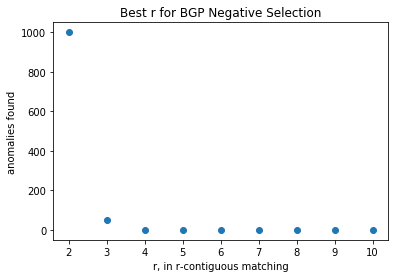

In [98]:
plt.figure()
plt.scatter(rRange, y)
plt.title("Best r for BGP Negative Selection")
plt.xlabel("r, in r-contiguous matching")
plt.ylabel("anomalies found")
plt.savefig("../Plots/contigBGP.eps")

In [131]:
for k in [1,2,5,10,15]:
    knn = KNeighborsClassifier(n_neighbors=k)

    transformedEng, engLabels = getTransformedData(trainingData, 0)

    trainSize = 50
    languageData = [fakePaths]
    for i in range(len(languageData)):
        tdata, tlabels = getTransformedData(languageData[i], 1)
        xtrain = transformedEng.copy()
        xtrain = np.append(xtrain, tdata[:trainSize], axis=0)
        ytrain = engLabels.copy()
        ytrain = np.append(ytrain, tlabels[:trainSize], axis=0)

        knn.fit(xtrain, ytrain)
        y_pred = knn.predict(tdata[trainSize:])
        anomalies = 0
        for y in y_pred:
            if(y==1):
                anomalies+=1

        print(str(k) + " & " + str(anomalies) + " & " + str(float(anomalies)/float(1000)) + " \\\\")

1 & 176 & 0.176 \\
2 & 48 & 0.048 \\
5 & 34 & 0.034 \\
10 & 2 & 0.002 \\
15 & 1 & 0.001 \\
